## Import Libraries

In [4]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf

from collections import deque
import matplotlib.pyplot as plt


%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, TimeDistributed, Flatten, GRU, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

### Convert Raw video datasets into a 320x240 at 20fps

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 320, 240  # Setting the requested resolution

def downgrade_video(input_video_path, output_video_path, target_resolution=(IMAGE_HEIGHT, IMAGE_WIDTH), target_fps=20):
    """
    Downgrades a video to a specified resolution and frame rate.

    Args:
        input_video_path (str): Path to the input video file.
        output_video_path (str): Path to save the output downgraded video file.
        target_resolution (tuple): Target width and height for the video frames.
        target_fps (int): Target frames per second for the output video.
    """
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {input_video_path}")
        return

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, target_fps, target_resolution)

    if not out.isOpened():
        print(f"Error: Could not open video writer for: {output_video_path}")
        cap.release()
        out.release()
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        resized_frame = cv2.resize(frame, target_resolution)
        out.write(resized_frame)

    cap.release()
    out.release()
    print(f"Downgraded: {input_video_path} to {output_video_path}")


def process_folder_structure(root_folder='raw'):  # Default input folder is 'raw'
    """
    Processes the folder structure to downgrade videos and save them in a new structure.

    Args:
        root_folder (str): Path to the root folder containing class folders.
    """
    output_root_folder = 'downgraded_raw'  # Output folder is fixed to 'downgraded_raw'
    os.makedirs(output_root_folder, exist_ok=True)

    class_folders = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    for class_name in class_folders:
        output_class_folder = os.path.join(output_root_folder, class_name)
        os.makedirs(output_class_folder, exist_ok=True)

        input_class_folder = os.path.join(root_folder, class_name)
        video_files = [f for f in os.listdir(input_class_folder) if f.lower().endswith(('.mp4', '.avi', '.mov'))]

        for video_file in video_files:
            input_video_path = os.path.join(input_class_folder, video_file)
            output_video_name = os.path.splitext(video_file)[0] + '_downgraded.mp4'
            output_video_path = os.path.join(output_class_folder, output_video_name)

            downgrade_video(input_video_path, output_video_path)


if __name__ == "__main__":
    input_root_folder = 'raw'  # Input folder is now hardcoded to 'raw'

    if not os.path.isdir(input_root_folder):
        print(f"Error: 'raw' folder not found in the same directory as the script.")
        sys.exit(1)

    process_folder_structure(input_root_folder)
    print(f"Downgrading process complete. Downgraded videos saved in 'downgraded_raw' folder.")

### Set Numpy, Python, and TF seeds

In [5]:
model_input_size = (224,224,3)
seed_constant = 7
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

batch_size = 8 # Change this shit pag sasabog na yung GPU

## Visualize Data for 1st CNN stream


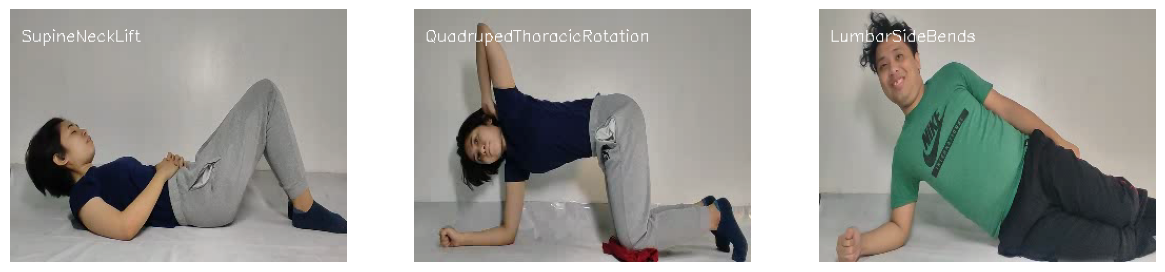

In [6]:
plt.figure(figsize = (20,20))

all_class_names = os.listdir('downgraded_raw')

random_range = random.sample(range(len(all_class_names)), 3)

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_class_names[random_index]

    video_files_names_list = os.listdir(f'downgraded_raw/{selected_class_name}') 
    selected_video_file_name =  random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'downgraded_raw/{selected_class_name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255),1)

    plt.subplot(5,4, counter);plt.imshow(rgb_frame);plt.axis('off')


## PreProcess the Dataset

In [10]:
IMAGE_HEIGHT, IMAGE_WIDTH =  64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = "/Users/patrickpadua/Downloads/Yango RRL/CSV Generator/CNN_GRU_usingRGBOF/downgraded_raw"

CLASSES_LIST = ['LumbarSideBends','QuadrupedThoracicRotation','SupineNeckLift']

## Extraction of Features 

1st Stream

In [54]:
def frames_extraction(video_path):
    """Extract frames from video and return normalized RGB frames"""
    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        
        success, frame = video_reader.read()
        
        if not success:
            break
        
        # Convert BGR to RGB before any other processing
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Resize and normalize
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame/255
        
        frames_list.append(normalized_frame)
    
    video_reader.release()
    
    # Pad with zeros if needed
    while len(frames_list) < SEQUENCE_LENGTH:
        frames_list.append(np.zeros_like(frames_list[-1]))
    
    return frames_list

2nd CNN Stream

## Dataset Creation

1st Stream

In [55]:
import numpy as np
import cv2
import albumentations as A
import os
import random

def denormalize_frames(frames):
    """Convert normalized frames (0-1) to uint8 format (0-255)"""
    return (np.array(frames) * 255).astype(np.uint8)

def normalize_frames(frames):
    """Convert uint8 frames (0-255) back to normalized format (0-1)"""
    return np.array(frames).astype(np.float32) / 255

def apply_augmentation(frames):
    """Apply various augmentation techniques to normalized frames"""
    # Convert to uint8 for augmentation
    uint8_frames = denormalize_frames(frames)
    augmented_frames = []
    
    # Define augmentation pipeline
    transform = A.Compose([
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        ], p=0.5),
        A.OneOf([
            A.ISONoise(p=0.5),
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        ], p=0.5),
    ])
    
    # Apply same transformation to all frames in sequence
    for frame in uint8_frames:
        # No need to convert to BGR since we're working directly with RGB
        augmented = transform(image=frame)
        augmented_frames.append(augmented['image'])
    
    # Convert back to normalized format
    return normalize_frames(augmented_frames)

def random_rotation(frames, max_angle=15):
    """Apply random rotation to normalized frames"""
    uint8_frames = denormalize_frames(frames)
    angle = np.random.uniform(-max_angle, max_angle)
    rotated_frames = []
    
    for frame in uint8_frames:
        matrix = cv2.getRotationMatrix2D((frame.shape[1]/2, frame.shape[0]/2), angle, 1.0)
        # Directly use the RGB frame with cv2.warpAffine
        rotated = cv2.warpAffine(frame, matrix, (frame.shape[1], frame.shape[0]),
                                flags=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_CONSTANT,
                                borderValue=(0, 0, 0))
        rotated_frames.append(rotated)
    
    return normalize_frames(rotated_frames)

def horizontal_flip(frames):
    """Flip normalized frames horizontally"""
    uint8_frames = denormalize_frames(frames)
    flipped_frames = []
    
    for frame in uint8_frames:
        # Directly flip the RGB frame
        flipped = cv2.flip(frame, 1)
        flipped_frames.append(flipped)
    
    return normalize_frames(flipped_frames)

def create_dataset_1st():
    """Creates the dataset with normalized video frames and augmentation"""
    features1 = []
    labels1 = []
    video_files_paths1 = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            try:
                # Make sure frames_extraction returns RGB frames
                frames = frames_extraction(video_file_path)
                
                if len(frames) == SEQUENCE_LENGTH:
                    # Add original frames
                    features1.append(frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path)
                    
                    # Add augmented versions
                    # 1. Random augmentation (brightness, contrast, noise, blur)
                    aug_frames = apply_augmentation(frames)
                    features1.append(aug_frames)
                    labels1.append(class_index)
                    video_files_paths1.append(video_file_path + '_aug')
                    
                    # 2. Random rotation (50% chance)
                    if random.random() < 0.5:
                        rot_frames = random_rotation(frames)
                        features1.append(rot_frames)
                        labels1.append(class_index)
                        video_files_paths1.append(video_file_path + '_rot')
                    
                    # 3. Horizontal flip (50% chance)
                    if random.random() < 0.5:
                        flip_frames = horizontal_flip(frames)
                        features1.append(flip_frames)
                        labels1.append(class_index)
                        video_files_paths1.append(video_file_path + '_flip')
            
            except Exception as e:
                print(f"Warning: Processing failed for {video_file_path}: {str(e)}")
                continue
    
    features1 = np.array(features1)
    labels1 = np.array(labels1)
    
    return features1, labels1, video_files_paths1

# Below are the changes for the augmentation
# Random Augmentation (using albumentations library):

# Brightness and contrast adjustments
# Hue, saturation, and value modifications
# Gaussian noise
# Gaussian blur


# Random Rotation:

# Applies random rotation up to 15 degrees
# Preserves frame dimensions


# Horizontal Flipping:

# Mirrors the frames horizontally
# Particularly useful for action recognition



# Key features of the implementation:

# Each original video has a chance to generate up to 3 additional augmented versions
# Augmentations are applied consistently across all frames in a sequence
# Random chance (50%) for rotation and flipping to maintain dataset balance
# Preserves the original video alongside augmented versions

In [56]:
#Create the dataset
features1, labels1, video_files_paths1 = create_dataset_1st()

Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift


In [57]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels1 = to_categorical(labels1)

In [58]:
# Display the converted labels
unique_labels, counts = np.unique(labels1, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} instances")

Label 0: 215 instances
Label 1: 213 instances
Label 2: 211 instances


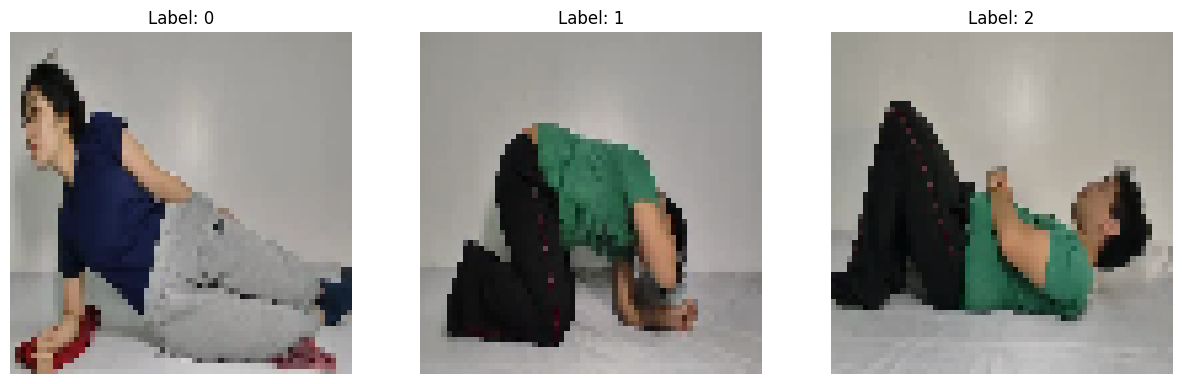

In [59]:
# Display a sample image for each of the three unique labels
plt.figure(figsize=(15, 5))

for i, label in enumerate(unique_labels):
    # Find the first index of the current label
    index = np.where(labels1 == label)[0][0]
    
    # Extract the corresponding video frames
    frames = features1[index]
    
    # Select the middle frame for display
    middle_frame = frames[len(frames) // 2]
    
    # Plot the frame
    plt.subplot(1, 3, i + 1)
    plt.imshow(middle_frame)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

2nd Stream

In [ ]:
def create_dataset_2nd():
    #extracts the data of the selected class asnd create the required dataset
    features2 = []
    labels2 = []
    video_files_paths2 = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features2.append(frames)
                labels2.append(class_index)
                video_files_paths2.append(video_file_path)
    
    features2 = np.asarray(features2)
    labels2 = np.array(labels2)

    return features2, labels2, video_files_paths2
            

In [ ]:
#Create the dataset
features2, labels2, video_files_paths2 = create_dataset_2nd()

In [ ]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels2 = to_categorical(labels2)

## Split Data into Train, Test, and Validation

For 1st Stream (RBG Data)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features1, one_hot_encoded_labels1,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)


For 2nd Stream (OF Data)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features2, one_hot_encoded_labels2,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)


## Implement 2stream Model